In [187]:
# ! pip install --upgrade pip
# ! pip install --upgrade numpy scipy matplotlib pyhf cabinetry uproot pandas

In [188]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import cabinetry
import pyhf
import json
from pathlib import Path

cabinetry.__version__

'0.5.2'

# Building the model

`Cabinetry` has the nice feature that it can crate `pyhf` models from `root` files. 

First we need to chose our fitting variable and the binning. Here we chose to fit in 50 bins of $\Delta E$.

In [189]:
bins = np.linspace(-0.4, 0.4, 50 + 1)

We define `cabinetry` models vie a `config` dictionary, containing different settings:

First, we give our measurement a name, denife a parameter of interest (POI), and input path containing the `root` files and a histogram folder, where cabinetry automatically saves the historgam yields.

In [190]:
cabinetry.set_logging()

BASE = Path('/home/belle/zhangboy/Summer_workshop_2023')

config = {
   "General":{
      "Measurement": "B2Kpi0",
      "POI": "Signal_norm",
      "InputPath": str(BASE / "{SamplePath}"), # wildcard for samples
      "HistogramFolder": "histograms/"

   }
}

Int the `Regions` setting, we tell `cabinetry` which variable in the `root` files it should load and define our signal region via the cut $| \Delta E | < 0.4 GeV$. It is a list, because we can use events from more than one phase space region. Additionally, we define the binning.

Next we can define our `Samples` again in a list, where we specify the name of each sample, the `root` file in the `InputPath`, the `Tree` and whether it is data or not. We can also pass a list of files as `SamplePath` and `cabinetry` will combine the files for us. 

In [191]:
config.update({
   "Regions":[
      {
         "Name": "signal_region",
         "Variable": "B_deltaE",             # which variable we bin histograms in
         "Filter": "abs(B_deltaE) < 0.4",           # event selection 
         "Binning": list(bins)
      }
   ]
})

config.update({
   "Samples":[
      {
         "Name": "Data",
         "SamplePath": ["sig_test.root","qqbar_test.root"],
         "Tree": "B",
         "Data": True                       # observed data is handled differently, need to distinguish
      },
      {
         "Name": "Signal",
         "SamplePath": "sig_template.root",
         "Tree": "B",
      },
      {
         "Name": "qqbar",
         "SamplePath": "qqbar_template.root",
         "Tree": "B",
      }
   ]
})

Lastly, we can add some modifiers: 

First, we add some normalisation factors for the signal and background. Here, we specify our `POI`, `Signal_norm`.

Then we can add some other systematics.


In [192]:
config.update({
   "NormFactors":[
      {
         "Name": "Signal_norm",
         "Samples": "Signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [-5, 10]
      },
        {
         "Name": "qqbar_norm",
         "Samples": "qqbar",    # we want this parameter to scale the misID
         "Nominal": 1,
         "Bounds": [-5, 10]
      }
   ]
})

config.update({
   "Systematics":[
   ],
})

`cabinetry` lets us validate our `config`,


In [193]:
cabinetry.configuration.validate(config)

True

Additionally, we can print an overview. We see that we have _ samples, _ regions, _ normalisation factors and _ systematics.

In [194]:
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   2 NormFactor(s)
INFO - cabinetry.configuration -   0 Systematic(s)


## Creating the histograms

Given that our validation succeeds, we can `build` the histrograms for our model. This will create the hisrograms from the `root` files and save them into the `HistogramFolder`.

In [195]:
cabinetry.templates.build(config, method="uproot")

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar.npz


You can also provide existing histograms you built yourself for `cabinetry` to use, see the [cabinetry-tutorials](https://github.com/cabinetry/cabinetry-tutorials) repository for an example.

We can now visualise what we produced:

INFO - cabinetry.visualize - visualizing histogram
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_qqbar_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_Signal_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_Data_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_prefit_log.pdf


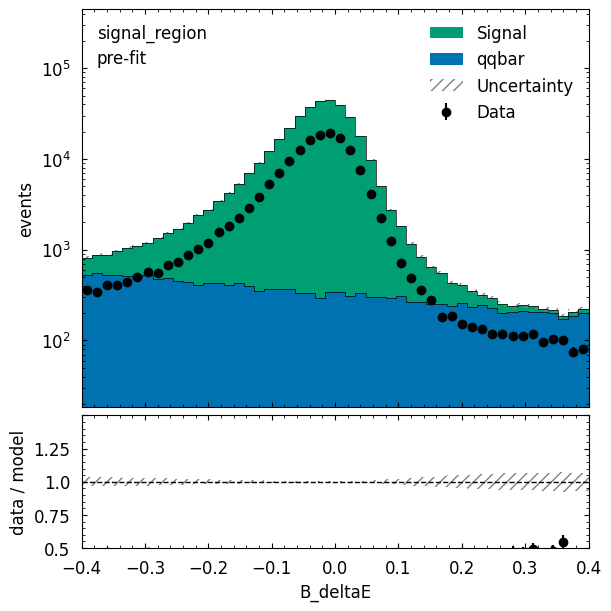

In [196]:
_ = cabinetry.visualize.data_mc_from_histograms(config)

`cabinetry` will automatically save this image in a `/figures` folder.

# Adding systematics

## Tracking efficiency

We rerun the reconstruction, removing some tracks. The resulting ntuples contain slightly different yields which tell us about the systematic uncertainty due to the tracking efficiency. 

In `cabinetry`, adding these uncertainties is very easy. We just specify the up- and down-variations via the new `root` file. Here we tell the configuration to syymetrize the variation. 

The `NormPlusShape` corresponds to a `histosys` modifier plus a `normsys` modifier. The `histosys` modifier takes care of the normalized shape variation due to our new samples and the `normsys` modifier takes care of the normaization differences of our nomial sample and the the modified one. `Cabinetry` will ive the modifiers the same name, `TrackingEfficiency`, which will tell `pyhf` that these modifiers are correlated. Hence we will only see 1 nuisance parameter in this case.



In [197]:
config.update({
   "Systematics":[
      {
         "Name":"TrackingEfficiency",
         "Up": {"SamplePath": "sig_test.root"},
         "Down": {"Symmetrize": True},
         "Samples": "Signal",
         "Type": "NormPlusShape"
      }
   ],
})

cabinetry.templates.build(config, method="uproot")

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Signal.npz
DEBUG - cabinetry.route -       variation TrackingEfficiency Up
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Signal_TrackingEfficiency_Up.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar.npz


In [198]:
(2*sum(nominal)-sum(modified))/sum(nominal)

1.571425302479906

In [199]:
np.load('histograms/signal_region_Signal_TrackingEfficiency_Up.npz')['yields']

array([1.0800e+02, 1.3400e+02, 1.8000e+02, 2.0100e+02, 2.2400e+02,
       2.8200e+02, 3.5300e+02, 3.5000e+02, 4.5600e+02, 5.4100e+02,
       6.8600e+02, 8.3400e+02, 9.9900e+02, 1.3520e+03, 1.6880e+03,
       2.0900e+03, 2.7560e+03, 3.6650e+03, 5.0570e+03, 6.8660e+03,
       9.3010e+03, 1.2486e+04, 1.5992e+04, 1.8370e+04, 1.9051e+04,
       1.6962e+04, 1.2272e+04, 7.5000e+03, 4.0100e+03, 2.0890e+03,
       1.1120e+03, 6.0500e+02, 3.5300e+02, 2.4700e+02, 1.7100e+02,
       9.6000e+01, 8.6000e+01, 6.0000e+01, 4.6000e+01, 4.3000e+01,
       3.2000e+01, 2.0000e+01, 2.4000e+01, 1.6000e+01, 2.5000e+01,
       9.0000e+00, 1.3000e+01, 9.0000e+00, 7.0000e+00, 5.0000e+00])

# Building a `pyhf` workspace

We now construct a `pyhf` workspace, which contains everything to build our likelihood function. This can also be used as an input file for `pyhf`. 

In [200]:
workspace_path = "b2kpi_workspace.json"
spec = cabinetry.workspace.build(config)
cabinetry.workspace.save(spec, workspace_path)

INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_Signal_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor Signal_norm to sample Signal in region signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys TrackingEfficiency to sample Signal in region signal_region
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_Signal_TrackingEfficiency_Up_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_Signal_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - normalization impact of systematic TrackingEfficiency on sample Signal in region signal_region is 0.429
WARNING - cabinetry.histo - 

In [201]:
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        292.0,
                        332.0,
                        348.0,
                        437.0,
                        546.0,
                        597.0,
                        667.0,
                        880.0,
                        1030.0,
                        1227.0,
                        1518.0,
                        2008.0,
                        2305.0,
                        3023.0,
                        3808.0,
                        4928.0,
                        6618.0,
                        8760.0,
                        11852.0,
                        16259.0,
                        21738.0,
                        29317.0,
                        36927.0,
                        43132.0,
                        44387.0,
                        39049.0,
                        2878

## Model structure

It can be helpful to visualize the modifier structure of the statistical model we have built to catch potential issues. The `visualize.modifier_grid` function creates a figure showcasing the information about which modifiers (indicated by color) act on which region and sample when a given parameter (on the horizontal axis) is varied.

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier TrackingEfficiency (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier qqbar_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (50 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


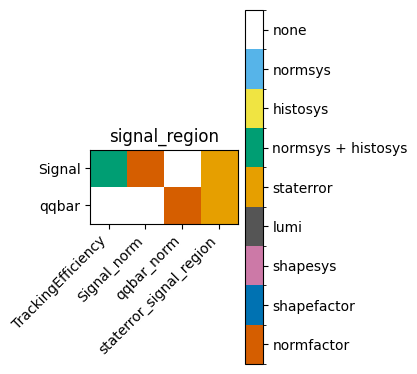

In [209]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

## Validating the systematics 

First let us check that we indeed only get 1 nuisance paramter for the `TrackingEfficiency` modifier:

In [227]:
model.config.par_names

['TrackingEfficiency',
 'Signal_norm',
 'qqbar_norm',
 'staterror_signal_region[0]',
 'staterror_signal_region[1]',
 'staterror_signal_region[2]',
 'staterror_signal_region[3]',
 'staterror_signal_region[4]',
 'staterror_signal_region[5]',
 'staterror_signal_region[6]',
 'staterror_signal_region[7]',
 'staterror_signal_region[8]',
 'staterror_signal_region[9]',
 'staterror_signal_region[10]',
 'staterror_signal_region[11]',
 'staterror_signal_region[12]',
 'staterror_signal_region[13]',
 'staterror_signal_region[14]',
 'staterror_signal_region[15]',
 'staterror_signal_region[16]',
 'staterror_signal_region[17]',
 'staterror_signal_region[18]',
 'staterror_signal_region[19]',
 'staterror_signal_region[20]',
 'staterror_signal_region[21]',
 'staterror_signal_region[22]',
 'staterror_signal_region[23]',
 'staterror_signal_region[24]',
 'staterror_signal_region[25]',
 'staterror_signal_region[26]',
 'staterror_signal_region[27]',
 'staterror_signal_region[28]',
 'staterror_signal_region[29


To check the numeric variations, we load the signal region Up-variation histogram for the `TrackingEfficiency`, which corresponds to the yields of the modified sample. To compare, we also load the nominal yields.

In [202]:
tracking_modified = np.load('/home/belle2/lorenzg/pyhf-tutorial/histograms/signal_region_Signal_TrackingEfficiency_Up.npz')['yields']
tracking_nominal = np.load('histograms/signal_region_Signal.npz')['yields']

First let us check the `normsys` variations. We expect:

In [203]:
spec['channels'][0]['samples'][0]['modifiers'][2]

{'name': 'TrackingEfficiency',
 'type': 'normsys',
 'data': {'hi': 0.4285746975200938, 'lo': 1.571425302479906}}

Here `hi` and `lo` are just labels for the numbers we interpolate between. It does not matter is `lo` is larger than `hi`.

We can calculate these values as the ratio of the total number of (possibly weighted) events. Make sure you understand the origin of these numbers.

In [228]:
sum(tracking_modified)/sum(tracking_nominal)

0.4285746975200938

In [229]:
(2*sum(tracking_nominal) - sum(tracking_modified))/sum(tracking_nominal)

1.571425302479906

Now let us check the `histosys` entries. We expect

In [230]:
spec['channels'][0]['samples'][0]['modifiers'][3]

{'name': 'TrackingEfficiency',
 'type': 'histosys',
 'data': {'hi_data': [251.99807787284595,
   312.6642818051978,
   419.9967964547433,
   468.9964227077966,
   522.6626800325694,
   657.9949811124311,
   823.6603841584688,
   816.6604375508897,
   1063.9918843520163,
   1262.3237049000895,
   1600.6544575997439,
   1945.9851569069772,
   2330.982220323825,
   3154.642604482294,
   3938.636624531148,
   4876.629469946741,
   6430.617616829291,
   8551.601438925745,
   11799.576664842425,
   16020.544469212597,
   21702.16779903093,
   29133.777780744025,
   37314.38204946808,
   42863.00639374241,
   44451.99427366286,
   39577.698119251974,
   28634.448256070053,
   17499.866518947634,
   9356.595298797336,
   4874.296154410881,
   2594.6468758759693,
   1411.6558991951092,
   823.6603841584688,
   576.3289373573422,
   398.9969566320061,
   223.99829144252973,
   200.66513608393288,
   139.9989321515811,
   107.3325146495455,
   100.33256804196644,
   74.66609714750992,
   46.66631

We calculate these numbers by calculating the differenced of the nominal yields to the correctly scaled modified ones.

In [231]:
scale = sum(modified)/sum(nominal)
modified/scale

array([2.51998078e+02, 3.12664282e+02, 4.19996796e+02, 4.68996423e+02,
       5.22662680e+02, 6.57994981e+02, 8.23660384e+02, 8.16660438e+02,
       1.06399188e+03, 1.26232370e+03, 1.60065446e+03, 1.94598516e+03,
       2.33098222e+03, 3.15464260e+03, 3.93863662e+03, 4.87662947e+03,
       6.43061762e+03, 8.55160144e+03, 1.17995767e+04, 1.60205445e+04,
       2.17021678e+04, 2.91337778e+04, 3.73143820e+04, 4.28630064e+04,
       4.44519943e+04, 3.95776981e+04, 2.86344483e+04, 1.74998665e+04,
       9.35659530e+03, 4.87429615e+03, 2.59464688e+03, 1.41165590e+03,
       8.23660384e+02, 5.76328937e+02, 3.98996957e+02, 2.23998291e+02,
       2.00665136e+02, 1.39998932e+02, 1.07332515e+02, 1.00332568e+02,
       7.46660971e+01, 4.66663107e+01, 5.59995729e+01, 3.73330486e+01,
       5.83328884e+01, 2.09998398e+01, 3.03331020e+01, 2.09998398e+01,
       1.63332088e+01, 1.16665777e+01])

In [232]:
2*nominal - modified / scale

array([3.32001922e+02, 3.51335718e+02, 2.76003204e+02, 4.05003577e+02,
       5.69337320e+02, 5.36005019e+02, 5.10339616e+02, 9.43339562e+02,
       9.96008116e+02, 1.19167630e+03, 1.43534554e+03, 2.07001484e+03,
       2.27901778e+03, 2.89135740e+03, 3.67736338e+03, 4.97937053e+03,
       6.80538238e+03, 8.96839856e+03, 1.19044233e+04, 1.64974555e+04,
       2.17738322e+04, 2.95002222e+04, 3.65396180e+04, 4.34009936e+04,
       4.43220057e+04, 3.85203019e+04, 2.89275517e+04, 1.78041335e+04,
       9.65940470e+03, 4.52170385e+03, 2.34535312e+03, 1.58834410e+03,
       9.84339616e+02, 5.67671063e+02, 3.77003043e+02, 3.94001709e+02,
       1.93334864e+02, 1.54001068e+02, 1.32667485e+02, 4.16674320e+01,
       5.73339029e+01, 6.53336893e+01, 1.60004271e+01, 2.66669514e+01,
       9.66711160e+00, 1.70001602e+01, 1.66689803e+00, 1.00016018e+00,
       2.36667912e+01, 2.43334223e+01])

Can you explain the origin of these formulae?

### Bonus: Also check the variations for the PID systematics

# Performing statistical inference

To perform inference, we need two things: a probability density function (pdf), or `model`, and data to fit it to. Both are derived from the workspace specification.

In [210]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier TrackingEfficiency (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier qqbar_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (50 new nuisance parameters)


We see that all the modifiers that we defined for our model appear here.

## Maximum likelihood estimate (MLE)

Let's fit our model to data to obtain the maximum likelihood estimate (MLE).

In [211]:
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
parameters

array([1.02216422, 1.01961026, 0.42311191, 1.02629094, 0.98312767,
       1.0068405 , 0.99057198, 1.00248172, 1.00711872, 0.99289874,
       1.00417137, 1.00562648, 1.0019239 , 0.99809295, 1.00353736,
       0.99985803, 1.00455481, 0.99668291, 0.996129  , 0.99921413,
       1.0011687 , 1.00153024, 0.99980204, 1.00031648, 1.00011078,
       0.99982108, 1.00003426, 0.99996708, 0.99966345, 1.00036286,
       0.99952768, 1.00006719, 0.99945266, 0.99988859, 0.99270495,
       1.01392239, 1.001524  , 0.99862613, 0.97311184, 1.0026256 ,
       0.97131646, 0.99329157, 0.96886342, 0.97112519, 1.03498709,
       1.0070403 , 1.01887638, 1.01819309, 0.99629741, 1.01681957,
       1.06366967, 0.96108649, 0.96772368])

In [212]:
fit_results = cabinetry.fit.fit(model, data, init_pars=list(parameters))

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 161                        │             Nfcn = 3493              │
│ EDM = 1.91e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────────────────

The fit converged, and we see the best-fit parameter results reported. The results are stored in a named tuple. This allows for easy access of the results. 

In [213]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

TrackingEfficiency: 1.022 +/- 0.163
Signal_norm: 1.020 +/- 0.141
qqbar_norm: 0.423 +/- 0.011
staterror_signal_region[0]: 1.026 +/- 0.030
staterror_signal_region[1]: 0.983 +/- 0.029
staterror_signal_region[2]: 1.007 +/- 0.028
staterror_signal_region[3]: 0.991 +/- 0.027
staterror_signal_region[4]: 1.002 +/- 0.026
staterror_signal_region[5]: 1.007 +/- 0.025
staterror_signal_region[6]: 0.993 +/- 0.025
staterror_signal_region[7]: 1.004 +/- 0.023
staterror_signal_region[8]: 1.006 +/- 0.021
staterror_signal_region[9]: 1.002 +/- 0.020
staterror_signal_region[10]: 0.998 +/- 0.019
staterror_signal_region[11]: 1.004 +/- 0.017
staterror_signal_region[12]: 1.000 +/- 0.016
staterror_signal_region[13]: 1.005 +/- 0.014
staterror_signal_region[14]: 0.997 +/- 0.013
staterror_signal_region[15]: 0.996 +/- 0.012
staterror_signal_region[16]: 0.999 +/- 0.010
staterror_signal_region[17]: 1.001 +/- 0.009
staterror_signal_region[18]: 1.002 +/- 0.008
staterror_signal_region[19]: 1.000 +/- 0.007
staterror_signal_

It is helpful to visualize the fit results. Let's start with the pull plot showing us best-fit parameter results.

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


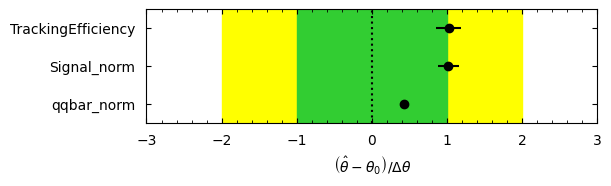

In [214]:
cabinetry.visualize.pulls(fit_results)

The parameter correlation matrix has a handy `pruning_threshold` setting to filter out parameters that are not highly correlated with others.

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


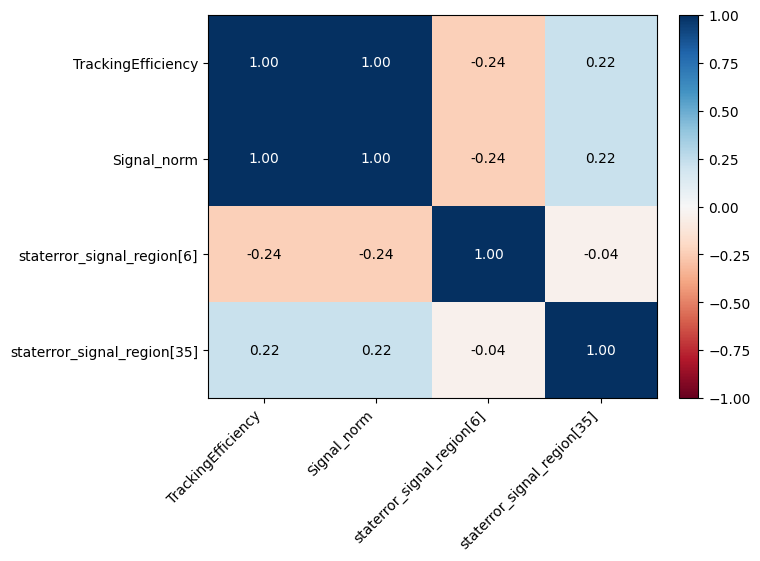

In [215]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.2)

Let us look at the post-fit result. This is as easy as passing `fit_results` to `cabinetry.model_utils.prediction`.

INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_postfit_log.pdf


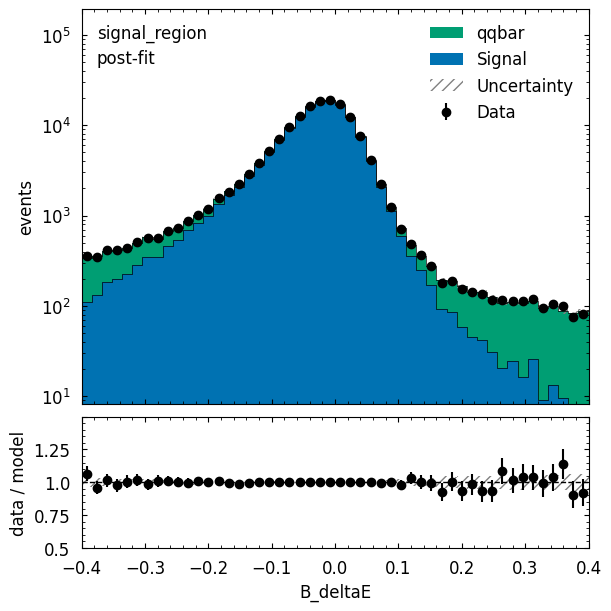

In [216]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=config)



Yield tables can also be created from a model prediction, and compared to data. Optional keyword arguments control whether yields per bin are shown (`per_bin=True`, default) and whether bins summed per region are shown (`per_channel=True`, disabled by default). The yield table is also saved to disk by default, in a format customizable via the `table_format` argument.



In [217]:
model_pred = cabinetry.model_utils.prediction(model)
_ = cabinetry.tabulate.yields(model_pred, data)

INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒══════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤════════════════════╤════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤══════════════════╤══════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════

# More advanced features

In [218]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 185.6                      │             Nfcn = 3528              │
│ EDM = 3.52e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 185.637724 at 

In [219]:
asimov_data

[818.0,
 880.0,
 876.0,
 963.0,
 1055.0,
 1100.0,
 1196.0,
 1356.0,
 1524.0,
 1680.0,
 1958.0,
 2412.0,
 2732.0,
 3458.0,
 4214.0,
 5362.0,
 7017.0,
 9111.0,
 12222.0,
 16629.0,
 22110.0,
 29648.0,
 37257.0,
 43429.0,
 44728.0,
 39392.0,
 29087.0,
 17987.0,
 9808.0,
 4998.0,
 2762.0,
 1807.0,
 1170.0,
 839.0,
 641.0,
 559.0,
 434.0,
 405.0,
 355.0,
 319.0,
 295.0,
 255.0,
 240.0,
 243.0,
 238.0,
 225.0,
 218.0,
 184.0,
 207.0,
 221.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [220]:
import copy
smoothing_config = copy.deepcopy(config)
smoothing_config["General"]["HistogramFolder"] = "histograms_smoothing/"
smoothing_config.update({
   "Systematics":[
      {
         "Name":"Modeling",
         "Up": {"SamplePath": "prediction.root", "Tree": "background_varied"},
         "Down": {"Symmetrize": True},
         "Samples": "Background",
         "Smoothing": {"Algorithm": "353QH, twice"},  # smoothing applied
         "Type": "NormPlusShape"
      }
   ]
})
cabinetry.templates.build(smoothing_config, method="uproot")
cabinetry.templates.postprocess(smoothing_config)
_ = cabinetry.visualize.templates(smoothing_config)

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/signal_region_qqbar.npz
DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.h

In [221]:
scan_results = cabinetry.fit.scan(model, data, "Signal_norm", n_steps=10, init_pars=list(parameters))

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 161                        │             Nfcn = 3493              │
│ EDM = 1.91e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 161.005073 at 

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 161.5                      │             Nfcn = 3794              │
│ EDM = 0.000138 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 161.496447 at 

INFO - cabinetry.visualize.utils - saving figure as figures/scan_Signal_norm.pdf


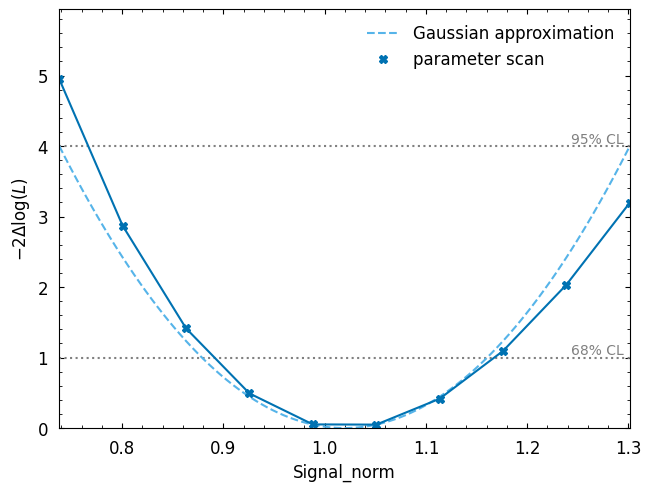

In [222]:
cabinetry.visualize.scan(scan_results)

In [223]:
# ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, init_pars=list(parameters))

In [224]:
# cabinetry.visualize.ranking(ranking_results)

In [225]:
# asimov_data = cabinetry.model_utils.asimov_data(model)
